In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install lime

%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#importando pacotes e bibliotecas para um SVM

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
#from sklearn.feature_extraction.text import CountVectorizer #converter os textos em uma matriz
from sklearn.feature_extraction.text import TfidfTransformer #frequencia que o termo aparece

#from sklearn.svm import LinearSVC, SVC # dados lineares / não lineares
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [3]:
#importando dataset

df = pd.read_csv("all-data.csv")

In [4]:
df.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
df.shape

(4846, 2)

<Axes: xlabel='sentiment', ylabel='count'>

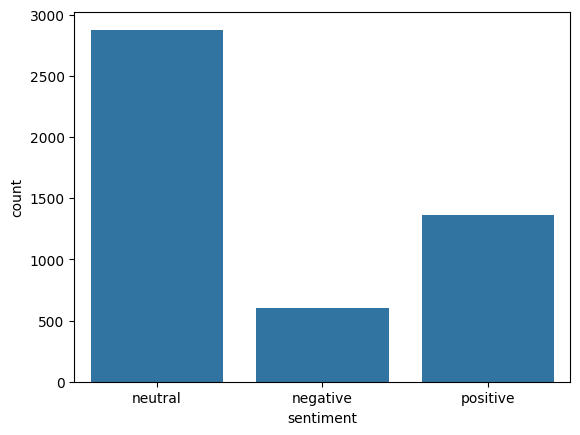

In [6]:
sns.countplot(x="sentiment", data=df) # Quantidade de classes

**Pré-processamento**

In [7]:
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [10]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

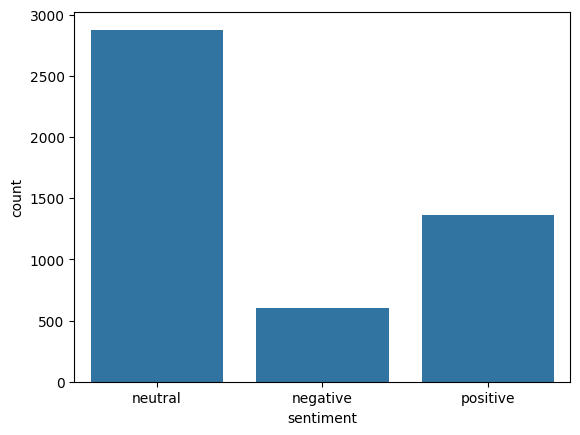

In [11]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

**OVERSAMPLING**

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
from imblearn.pipeline import Pipeline as imbpipeline #importa o pipeline do imblearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE

X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_smote = imbpipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC())
])

pipeline_smote.fit(X_train, y_train)
y_pred_smote = pipeline_smote.predict(X_test)

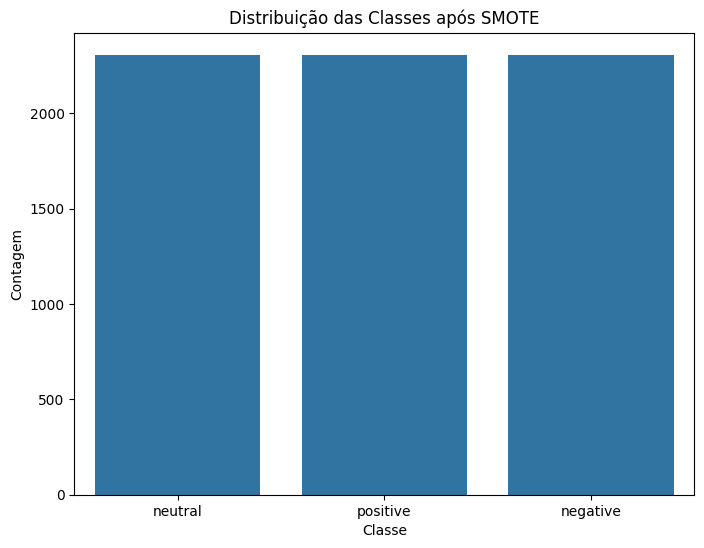

Contagem das classes após SMOTE:
sentiment
neutral     2308
positive    2308
negative    2308
Name: count, dtype: int64


In [14]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib
# Obter as classes balanceadas após o SMOTE
y_resampled = pipeline_smote.named_steps['smote'].fit_resample(
    pipeline_smote.named_steps['vect'].fit_transform(X_train), y_train
)[1]

# Contar a distribuição das classes
class_distribution = pd.Series(y_resampled).value_counts()

# Visualizar a distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Distribuição das Classes após SMOTE')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

# Imprimir a contagem das classes
print('Contagem das classes após SMOTE:')
print(class_distribution)

**LIME**

In [15]:
# Assuming 'text' is the column name containing the text data and 'sentiment' is the target column
X = df['clean_text']
y = df['sentiment']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from IPython.display import display
from lime.lime_text import LimeTextExplainer


def predict_proba(texts):
    # LIME espera probabilidades, mas LinearSVC não tem predict_proba.
    # Usamos decision_function e normalizamos para somar 1 (softmax-like).
    scores = pipeline_smote.decision_function(texts)
    # Se for 1D (binary), transforma em 2D
    if len(scores.shape) == 1:
        scores = np.vstack([-scores, scores]).T
    # Softmax para converter scores em "probabilidades"
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
    return probs

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
pred_class_name = pipeline_smote.predict([sample_text])[0]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Real class: {sample_label}")
print(f"Classe predita: {pred_class_name}")

# Criando o explainer
explainer = LimeTextExplainer(class_names=list(pipeline_smote.classes_))

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

Número da linha no X_test: 499
Original text:
preliminary estimation technology park measure square meter
Real class: neutral
Classe predita: neutral


In [18]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")


Palavras mais importantes e seus pesos:
square: 0.1117
technology: -0.0924
meter: 0.0711
measure: 0.0422
park: 0.0418
estimation: 0.0179
preliminary: -0.0178


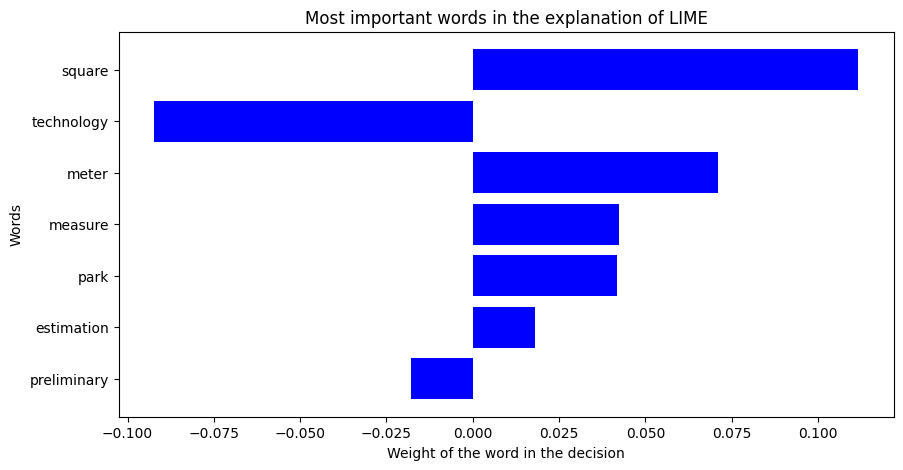

In [19]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [20]:
explanation_list = explanation.as_list()
lime_df = pd.DataFrame(explanation_list, columns=["Word", "Impact"])

# Ordenar por impacto
lime_df = lime_df.sort_values(by="Impact", ascending=False)

display(lime_df.head(20))  # Exibir as 20 palavras mais impactantes

,Word,Impact
0,square,0.111720
2,meter,0.071062
3,measure,0.042217
4,park,0.041842
5,estimation,0.017911
6,preliminary,-0.017819
1,technology,-0.092383


<Figure size 1000x600 with 0 Axes>

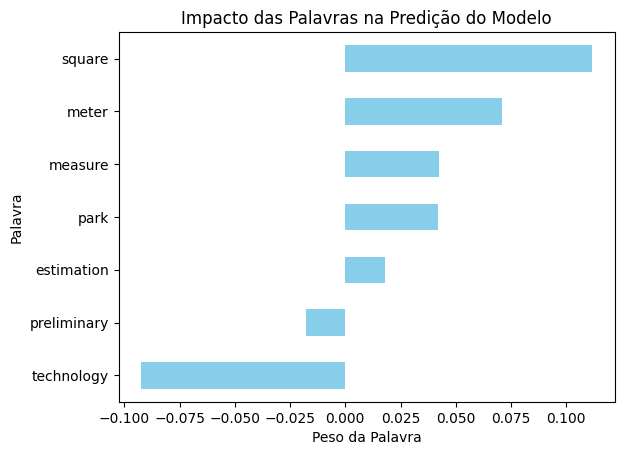

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lime_df.plot(kind="barh", x="Word", y="Impact", color="skyblue", legend=False)
plt.xlabel("Peso da Palavra")
plt.ylabel("Palavra")
plt.title("Impacto das Palavras na Predição do Modelo")
plt.gca().invert_yaxis()  # Inverte o eixo para as palavras mais importantes ficarem no topo
plt.show()

In [22]:
y_pred = pipeline_smote.predict(X_test)

**Métricas**

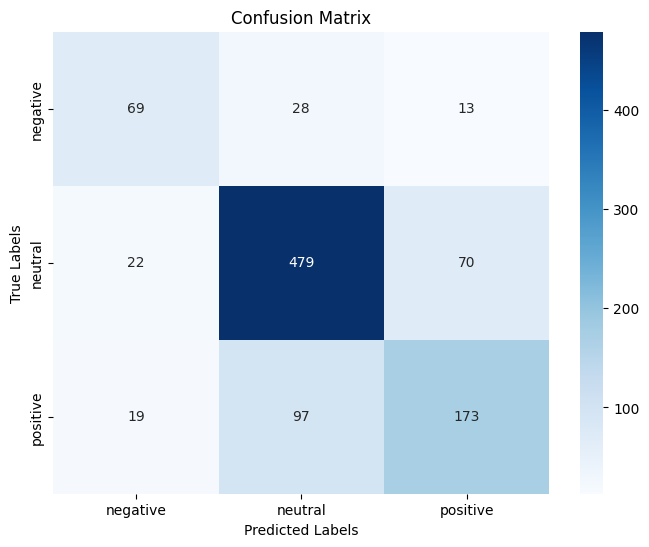

In [23]:
# prompt: matriz de confusão

import matplotlib.pyplot as plt
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipeline_smote.classes_, yticklabels=pipeline_smote.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Usando 'weighted' para classes múltiplas
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.7433
Precisão: 0.7393
Recall: 0.7433
F1-Score: 0.7402


**Attention Vizualization**

In [25]:
#verificando a ordem das classes
print(pipeline_smote.classes_)

['negative' 'neutral' 'positive']


Palavras do exemplo e seus pesos na decisão da classe prevista:
          Feature    Weight
6338       square  0.908926
4055      measure  0.629941
4119        meter  0.587859
4796         park  0.498470
2087   estimation  0.256468
5119  preliminary  0.005476
6694   technology -0.871452


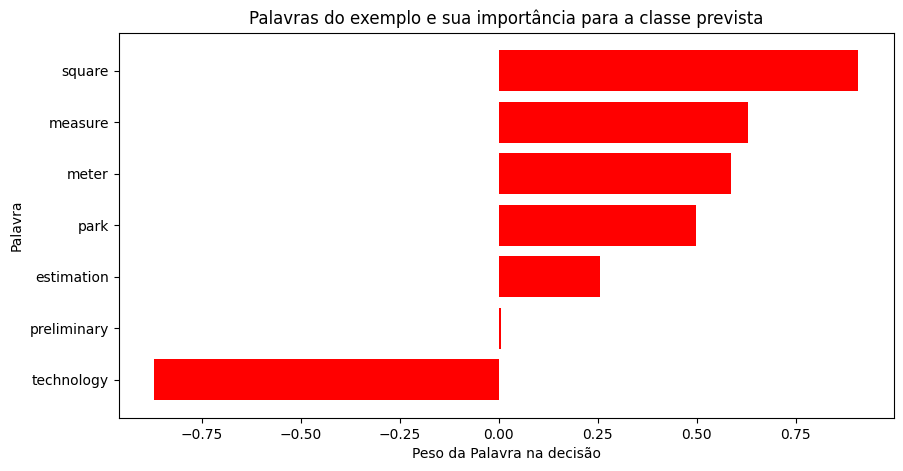

In [26]:
# Use o mesmo sample_text do LIME
feature_names = pipeline_smote.named_steps['vect'].get_feature_names_out()

classe_prevista = pipeline_smote.predict([sample_text])[0]
classe_idx = list(pipeline_smote.classes_).index(classe_prevista)
pesos = pipeline_smote.named_steps['clf'].coef_[classe_idx]

importancias = pd.DataFrame({'Feature': feature_names, 'Weight': pesos})
palavras_exemplo = set(sample_text.split())
importancias['No_Exemplo'] = importancias['Feature'].apply(lambda x: x in palavras_exemplo)
importancias_exemplo = importancias[importancias['No_Exemplo']].sort_values(by='Weight', ascending=False)

print("Palavras do exemplo e seus pesos na decisão da classe prevista:")
print(importancias_exemplo[['Feature', 'Weight']])

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo['Feature'], importancias_exemplo['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title("Palavras do exemplo e sua importância para a classe prevista")
plt.gca().invert_yaxis()
plt.show()

In [27]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline_smote.named_steps['clf'].coef_[0]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline_smote.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

          Feature    Weight
1546    decreased  5.438620
2282         fell  4.167243
1808      dropped  3.757631
1540     declined  3.136245
3847        lower  2.593099
1479          cut  2.570450
6187      slipped  2.309441
5652       result  2.276439
886      canceled  2.232453
7371     weakened  2.153834
830      burdened  2.103654
6736  temporarily  2.095036
2238         fall  2.064205
1807         drop  1.959951
7370         weak  1.947453
7404         went  1.922966
3655       layoff  1.909695
7346      warning  1.879143
6353        staff  1.877861
4793       parent  1.866599


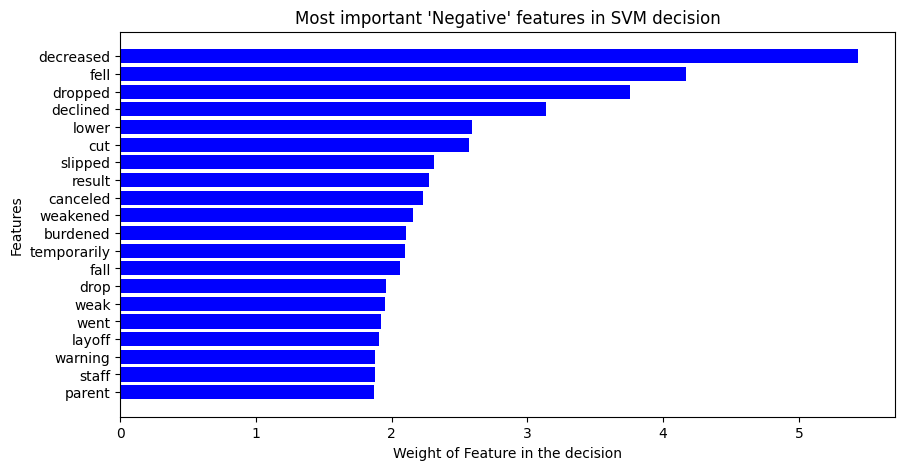

In [28]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Negative' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [29]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline_smote.named_steps['clf'].coef_[1]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline_smote.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

            Feature    Weight
337   approximately  1.933081
2808  headquartered  1.907162
7188          value  1.881121
3053       includes  1.816201
4742      ownership  1.464699
4877        pension  1.425094
4802           part  1.409786
1643    development  1.402211
255           among  1.401153
1927    electricity  1.387357
1700    discontinue  1.366183
4565          offer  1.364969
6369        started  1.348328
5133        present  1.310406
5364          range  1.279964
1594      depending  1.252513
1511           date  1.247695
4184         mining  1.235158
3305        january  1.234450
474      automotive  1.222478


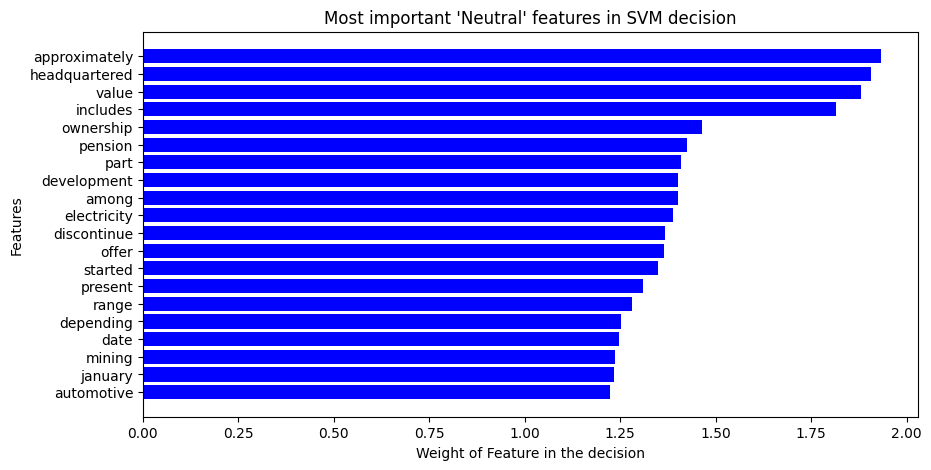

In [30]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Neutral' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [31]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline_smote.named_steps['clf'].coef_[2]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline_smote.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
import pandas as pd
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

          Feature    Weight
5743         rose  4.151248
3063    increased  3.707753
2690         grew  3.569145
5072     positive  3.460261
3062     increase  3.460136
6111       signed  2.745104
3035     improved  2.699266
492       awarded  2.582647
7553   yearonyear  2.557927
5398        reach  2.411264
4337     narrowed  2.386527
3375       jumped  2.370289
3664      leading  2.337688
12           able  2.299818
2168       expand  2.237813
1776      doubled  2.151178
2704         grow  2.125292
5702         rise  2.067226
5353       raised  2.049228
3036  improvement  2.031025


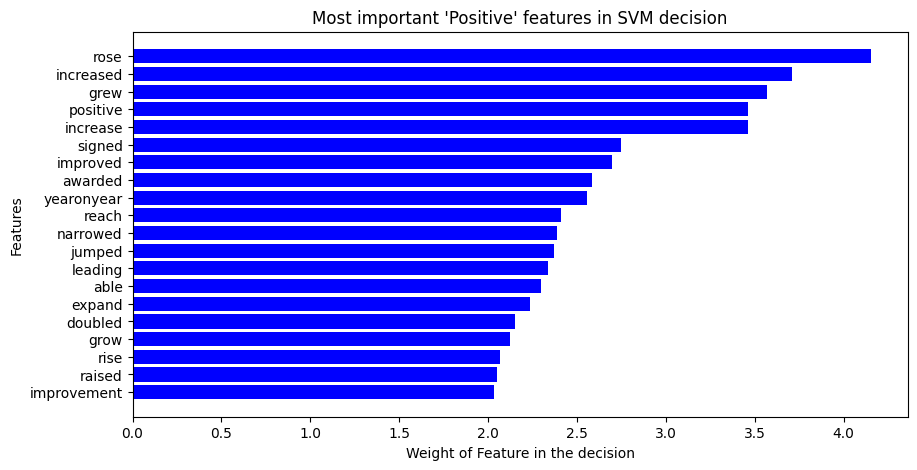

In [32]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Positive' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [39]:
# Contar a distribuição das classes pós balanceamento em tabela
class_distribution = pd.Series(y_resampled).value_counts()
class_distribution2 = pd.Series(y_test).value_counts()
# Exibir a distribuição das classes
print("Distribuição das classes após balanceamento:")
print(class_distribution)

print("Distribuição das classes de teste:")
print(class_distribution2)

Distribuição das classes após balanceamento:
sentiment
neutral     2308
positive    2308
negative    2308
Name: count, dtype: int64
Distribuição das classes de teste:
sentiment
neutral     571
positive    289
negative    110
Name: count, dtype: int64
